## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import urllib.request
import lightgbm as lgb
import os
import re
from bootcampviztools import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./train.csv", index_col=0)
df.index.name = None

## Exploración de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [5]:
df.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00
229,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42kg,2456.34


## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [6]:
df["inches"] = df.Inches.astype(float)
df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)
df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)
df = df.drop(columns=["Inches", "Ram", "Weight"])

Extraer información de 'ScreenResolution


In [7]:
df.ScreenResolution.value_counts()

ScreenResolution
Full HD 1920x1080                                349
1366x768                                         211
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         32
Full HD / Touchscreen 1920x1080                   30
1600x900                                          14
Quad HD+ / Touchscreen 3200x1800                  11
Touchscreen 1366x768                              11
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     10
4K Ultra HD / Touchscreen 3840x2160                7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
Touchscreen 2560x1440                              6
IPS Panel 4K Ultra HD 3840x2160                    5
Touchscreen 2256x1504                              5
IPS Panel Retina Display 2560x1600                 5
1440x900                                           4
IPS Panel 1366x768                                 4
IPS Panel Retina Display 2304x1440                 4
IPS Panel Touchscreen 2560x14

In [8]:
# Separo Touchscreens y IPSs
df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False, na=False).astype(int)
df['IPS'] = df['ScreenResolution'].str.contains('IPS', case=False, na=False).astype(int)

# Separo Resolucion X e Y
resoluciones = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
df['Resolucion_X'] = resoluciones[0].astype(float)
df['Resolucion_Y'] = resoluciones[1].astype(float)

# Calcular PPI (Pixeles Por Pulgada)
df['PPI'] = ((df['Resolucion_X']**2 + df['Resolucion_Y']**2) ** 0.5) / df['inches']
df.drop(columns=['ScreenResolution'], inplace=True)


Desfragmento columna "Memory" para obtener datos utiles

In [9]:
def process_memory(memory):
    """Extrae la capacidad total en GB y el tipo de almacenamiento."""
    memory = memory.lower().replace('tb', '000').replace('gb', '')
    parts = re.findall(r'(\d+)\s*([a-zA-Z]+)', memory)
    
    total_storage = 0
    ssd, hdd, flash, hybrid = 0, 0, 0, 0
    
    for size, storage_type in parts:
        size = int(size)
        if 'ssd' in storage_type:
            ssd += size
        elif 'hdd' in storage_type:
            hdd += size
        elif 'flash' in storage_type:
            flash += size
        elif 'hybrid' in storage_type:
            hybrid += size
        total_storage += size

    return pd.Series([total_storage, ssd, hdd, flash, hybrid])

df[['Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_GB', 'Hybrid_GB']] = df['Memory'].apply(process_memory)
df.drop(columns=['Memory'], inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Cpu               912 non-null    object 
 4   Gpu               912 non-null    object 
 5   OpSys             912 non-null    object 
 6   Price_in_euros    912 non-null    float64
 7   inches            912 non-null    float64
 8   ram_gb            912 non-null    int32  
 9   weight_kg         912 non-null    float64
 10  Touchscreen       912 non-null    int32  
 11  IPS               912 non-null    int32  
 12  Resolucion_X      912 non-null    float64
 13  Resolucion_Y      912 non-null    float64
 14  PPI               912 non-null    float64
 15  Total_Storage_GB  912 non-null    int64  
 16  SSD_GB            912 non-null    int64  
 17  

Codificar variables categóricas con One-Hot Encoding

In [11]:
categorical_columns = ['Company', 'TypeName', 'Cpu', 'Gpu', 'OpSys', 'Product']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

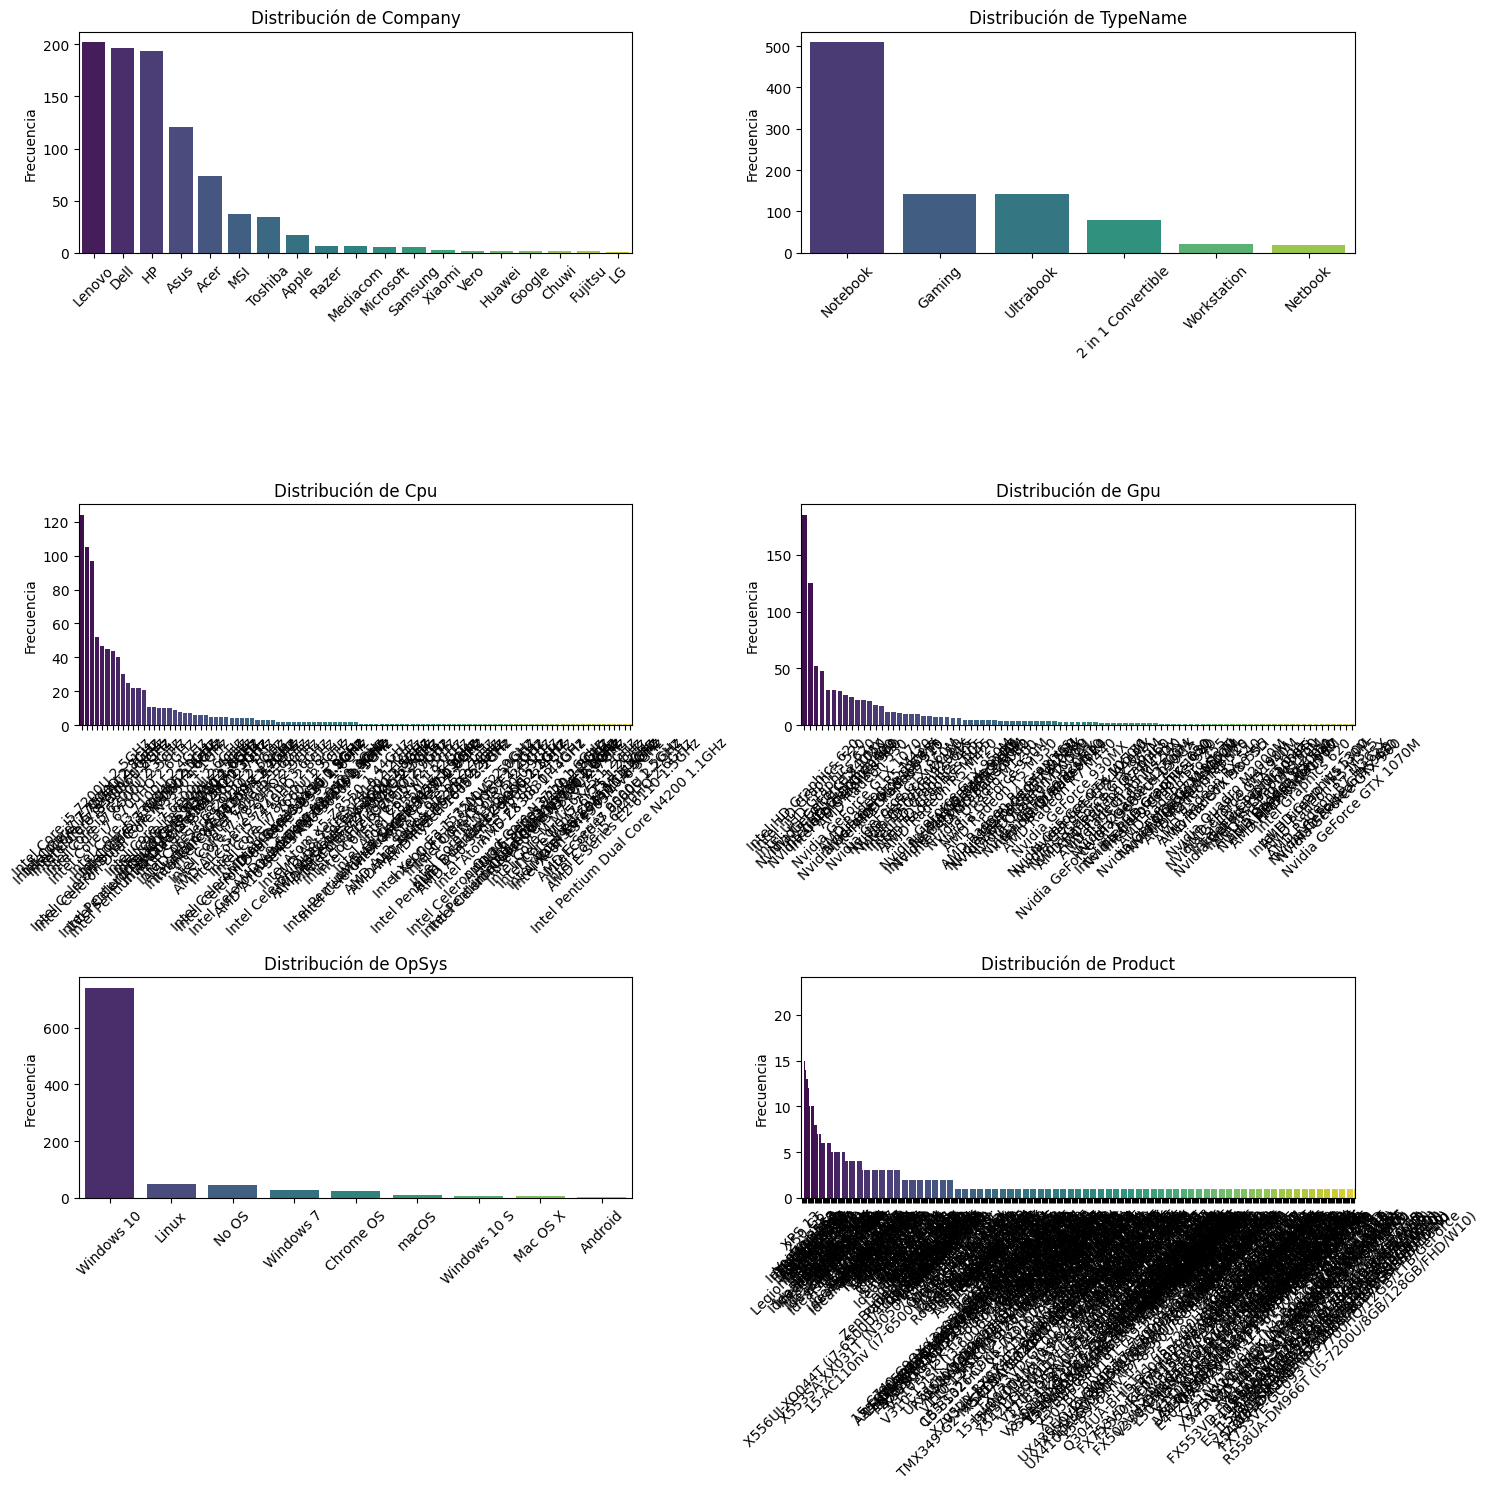

In [12]:
pinta_distribucion_categoricas(df, categorical_columns)

In [13]:
df_encoded

,Price_in_euros,inches,ram_gb,weight_kg,Touchscreen,IPS,Resolucion_X,Resolucion_Y,PPI,Total_Storage_GB,...,Product_ZenBook UX430UA,Product_ZenBook UX430UN,Product_ZenBook UX510UX-CN211T,Product_ZenBook UX530UQ-PRO,Product_Zenbook 3,Product_Zenbook Flip,Product_Zenbook UX390UA,Product_Zenbook UX410UA-GV027T,Product_Zenbook UX430UA,Product_Zenbook UX510UW-FI095T
755,539.00,15.6,8,1.86,0,0,1920.0,1080.0,141.211998,256,...,False,False,False,False,False,False,False,False,False,False
618,879.01,15.6,16,2.59,0,0,1920.0,1080.0,141.211998,1000,...,False,False,False,False,False,False,False,False,False,False
909,900.00,15.6,8,2.04,0,0,1920.0,1080.0,141.211998,1000,...,False,False,False,False,False,False,False,False,False,False
2,898.94,13.3,8,1.34,0,0,1440.0,900.0,127.677940,128,...,False,False,False,False,False,False,False,False,False,False
286,428.00,15.6,4,2.25,0,0,1920.0,1080.0,141.211998,1000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,800.00,15.6,8,2.20,0,0,1920.0,1080.0,141.211998,256,...,False,False,False,False,False,False,False,False,False,False
1160,1629.00,13.3,8,1.48,1,0,1920.0,1080.0,165.632118,256,...,False,False,False,False,False,False,False,False,False,False
78,519.00,15.6,8,2.20,0,0,1920.0,1080.0,141.211998,2000,...,False,False,False,False,False,False,False,False,False,False
23,258.00,15.6,4,1.86,0,0,1366.0,768.0,100.454670,500,...,False,False,False,False,False,False,False,False,False,False


-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [14]:
X = df_encoded.drop(columns=['Price_in_euros'])
y = df_encoded['Price_in_euros']

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Columns: 721 entries, inches to Product_Zenbook UX510UW-FI095T
dtypes: bool(708), float64(5), int32(3), int64(5)
memory usage: 719.6 KB


In [16]:
y

755      539.00
618      879.01
909      900.00
2        898.94
286      428.00
         ...   
28       800.00
1160    1629.00
78       519.00
23       258.00
229     2456.34
Name: Price_in_euros, Length: 912, dtype: float64

In [17]:
X.shape

(912, 721)

In [18]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### 3. Entrenamiento DE LightGBM


In [37]:
RFmodel = RandomForestRegressor()
RFmodel.fit(X_train, y_train)

RandomForestRegressor()

In [38]:
y_pred = RFmodel.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [39]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [40]:
rmse

329.55169130214665

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [28]:
X_pred = pd.read_csv("./test.csv", index_col= 0)
X_pred.index.name = None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [29]:
X_pred.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [30]:
X_pred["inches"] = X_pred.Inches.astype(float)
X_pred['ram_gb'] = X_pred['Ram'].str.replace('GB', '').astype(int)
X_pred["weight_kg"] = X_pred['Weight'].str.replace('kg', '').astype(float)
X_pred = X_pred.drop(columns=["Inches", "Ram", "Weight"])

In [31]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   Product           391 non-null    object 
 2   TypeName          391 non-null    object 
 3   ScreenResolution  391 non-null    object 
 4   Cpu               391 non-null    object 
 5   Memory            391 non-null    object 
 6   Gpu               391 non-null    object 
 7   OpSys             391 non-null    object 
 8   inches            391 non-null    float64
 9   ram_gb            391 non-null    int32  
 10  weight_kg         391 non-null    float64
dtypes: float64(2), int32(1), object(8)
memory usage: 35.1+ KB


In [32]:
# Separo Touchscreens y IPSs
X_pred['Touchscreen'] = X_pred['ScreenResolution'].str.contains('Touchscreen', case=False, na=False).astype(int)
X_pred['IPS'] = X_pred['ScreenResolution'].str.contains('IPS', case=False, na=False).astype(int)

# Separo Resolucion X e Y
resoluciones = X_pred['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
X_pred['Resolucion_X'] = resoluciones[0].astype(float)
X_pred['Resolucion_Y'] = resoluciones[1].astype(float)

# Calcular PPI (Pixeles Por Pulgada)
X_pred['PPI'] = ((X_pred['Resolucion_X']**2 + X_pred['Resolucion_Y']**2) ** 0.5) / X_pred['inches']
X_pred.drop(columns=['ScreenResolution'], inplace=True)


In [33]:
X_pred[['Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_GB', 'Hybrid_GB']] = X_pred['Memory'].apply(process_memory)
X_pred.drop(columns=['Memory'], inplace=True)


In [34]:
X_train
# X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
# # Aplicar One-Hot Encoding
# X_pred_encoded = pd.get_dummies(X_pred, columns=categorical_columns, drop_first=True)
# X_pred_encoded = X_pred_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


,inches,ram_gb,weight_kg,Touchscreen,IPS,Resolucion_X,Resolucion_Y,PPI,Total_Storage_GB,SSD_GB,...,Product_ZenBookUX430UA,Product_ZenBookUX430UN,Product_ZenBookUX510UXCN211T,Product_ZenBookUX530UQPRO,Product_Zenbook3,Product_ZenbookFlip,Product_ZenbookUX390UA,Product_ZenbookUX410UAGV027T,Product_ZenbookUX430UA,Product_ZenbookUX510UWFI095T
1118,17.3,8,3.00,0,1,1920.0,1080.0,127.335675,1000,0,...,False,False,False,False,False,False,False,False,False,False
153,15.6,16,2.56,0,0,1920.0,1080.0,141.211998,512,512,...,False,False,False,False,False,False,False,False,False,False
275,13.3,8,1.37,0,1,2560.0,1600.0,226.983005,512,512,...,False,False,False,False,False,False,False,False,False,False
1100,14.0,4,1.54,0,0,1920.0,1080.0,157.350512,500,0,...,False,False,False,False,False,False,False,False,False,False
131,17.3,16,2.80,0,0,1920.0,1080.0,127.335675,2256,256,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,14.0,8,1.94,0,0,1366.0,768.0,111.935204,2000,0,...,False,False,False,False,False,False,False,False,False,False
996,15.6,6,2.20,0,0,1920.0,1080.0,141.211998,256,256,...,False,False,False,False,False,False,False,False,False,False
770,12.5,16,1.18,0,0,1920.0,1080.0,176.232574,256,256,...,False,False,False,False,False,False,False,False,False,False
407,15.6,4,2.20,0,0,1366.0,768.0,100.454670,1000,0,...,False,False,False,False,False,False,False,False,False,False


 ## 2. Replicar el procesado para ``test.csv``

In [35]:
X_pred

,Company,Product,TypeName,Cpu,Gpu,OpSys,inches,ram_gb,weight_kg,Touchscreen,IPS,Resolucion_X,Resolucion_Y,PPI,Total_Storage_GB,SSD_GB,HDD_GB,Flash_GB,Hybrid_GB
209,Lenovo,Legion Y520-15IKBN,Gaming,Intel Core i7 7700HQ 2.8GHz,Nvidia GeForce GTX 1060,No OS,15.6,16,2.400,0,0,1920.0,1080.0,141.211998,512,512,0,0,0
1281,Acer,Aspire ES1-531,Notebook,Intel Celeron Dual Core N3060 1.6GHz,Intel HD Graphics 400,Linux,15.6,4,2.400,0,0,1366.0,768.0,100.454670,500,0,500,0,0
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,Intel Core i3 6006U 2.0GHz,Intel HD Graphics 520,No OS,15.6,4,1.900,0,0,1366.0,768.0,100.454670,1000,0,1000,0,0
1231,Dell,Inspiron 7579,2 in 1 Convertible,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,15.6,8,2.191,1,1,1920.0,1080.0,141.211998,256,256,0,0,0
1020,HP,ProBook 640,Notebook,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,14.0,4,1.950,0,0,1920.0,1080.0,157.350512,256,256,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,Intel Core i7 7700HQ 2.8GHz,Nvidia GeForce GTX 1070,Windows 10,17.3,16,2.900,0,0,1920.0,1080.0,127.335675,1512,512,1000,0,0
948,Toshiba,Tecra Z40-C-12X,Notebook,Intel Core i5 6200U 2.3GHz,Intel HD Graphics 520,Windows 10,14.0,4,1.470,0,1,1920.0,1080.0,157.350512,128,128,0,0,0
483,Dell,Precision M5520,Workstation,Intel Core i7 7700HQ 2.8GHz,Nvidia Quadro M1200,Windows 10,15.6,8,1.780,0,0,1920.0,1080.0,141.211998,256,256,0,0,0
1017,HP,Probook 440,Notebook,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,14.0,4,1.640,0,0,1366.0,768.0,111.935204,500,0,500,0,0


In [43]:
predictions_submit = RFmodel.predict(X_pred)
predictions_submit

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Company
- Cpu
- Gpu
- OpSys
- Product
- ...
Feature names seen at fit time, yet now missing:
- Company_Apple
- Company_Asus
- Company_Chuwi
- Company_Dell
- Company_Fujitsu
- ...


**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

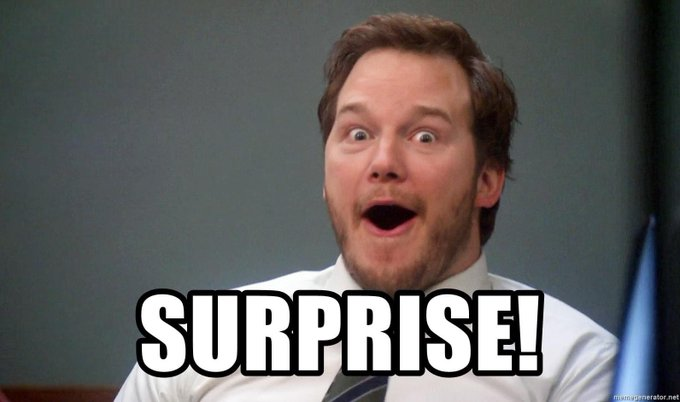

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("./sample_submission.csv")

In [ ]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [ ]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [ ]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": X_pred.index,"Price_in_euros":predictions_submit})

In [ ]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1494.218803
1,1281,470.997885
2,1168,485.871395
3,1231,806.678955
4,1020,1091.568500


In [33]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [34]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    filename = "submission.csv"

    if os.path.exists(filename):
        i = 2
        while os.path.exists(f"submission_v{i}.csv"):
            i += 1
        filename = f"submission_v{i}.csv"

    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv(filename, index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [35]:
chequeador(submission)

You're ready to submit!
